In [134]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("TASK-ML-INTERN.csv")  # Replace with your dataset
X = data.drop(['hsi_id', 'vomitoxin_ppb'], axis=1).values 
y = data['vomitoxin_ppb'].values # Target variable

# Normalize/standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN input
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])  # (num_samples, num_channels, sequence_length)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [135]:
import torch
import torch.nn as nn
import torch.optim as optim

class HyperspectralCNN(nn.Module):
    def __init__(self, input_length):
        super(HyperspectralCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)  # Batch normalization
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)  # Batch normalization
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # Pooling
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * (input_length // 4), 128)  # Adjust input_length // 4 based on pooling
        self.dropout = nn.Dropout(0.1)  # Dropout for regularization
        self.fc2 = nn.Linear(128, 1)  # Output layer for regression

    def forward(self, x):
        # Convolutional block 1
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        # Convolutional block 2
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected block
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize model
input_length = X_train.shape[2]  # Number of wavelength bands
model = HyperspectralCNN(input_length)

In [ ]:
# Define loss and optimizer
criterion = nn.MSELoss()  # Regression loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Training loop
num_epochs = 50000
training_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    training_losses.append(loss)
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/50000], Loss: 153730752.0000
Epoch [101/50000], Loss: 134947264.0000
Epoch [201/50000], Loss: 92866344.0000
Epoch [301/50000], Loss: 47896260.0000
Epoch [401/50000], Loss: 18608922.0000
Epoch [501/50000], Loss: 6738512.5000
Epoch [601/50000], Loss: 3792791.0000
Epoch [701/50000], Loss: 2428363.2500
Epoch [801/50000], Loss: 1395499.3750
Epoch [901/50000], Loss: 1376736.5000
Epoch [1001/50000], Loss: 1108149.6250
Epoch [1101/50000], Loss: 1100868.1250
Epoch [1201/50000], Loss: 1129671.0000
Epoch [1301/50000], Loss: 1210017.6250
Epoch [1401/50000], Loss: 860454.6250
Epoch [1501/50000], Loss: 623107.3125
Epoch [1601/50000], Loss: 573039.6250
Epoch [1701/50000], Loss: 912786.8750
Epoch [1801/50000], Loss: 732510.7500
Epoch [1901/50000], Loss: 1020765.6875
Epoch [2001/50000], Loss: 1111035.7500
Epoch [2101/50000], Loss: 609057.6250
Epoch [2201/50000], Loss: 618087.5000
Epoch [2301/50000], Loss: 462193.3750
Epoch [2401/50000], Loss: 781526.0625
Epoch [2501/50000], Loss: 487769.6875
E

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.grid(True)
plt.legend()
# Add log scale for y-axis if loss values vary significantly
plt.yscale('log')  # Remove this line if you want linear scale
plt.tight_layout()
plt.show()

In [132]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    
# Convert predictions to numpy
predictions = predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate metrics
mae = mean_absolute_error(y_test_np, predictions)
rmse = np.sqrt(mean_squared_error(y_test_np, predictions))
r2 = r2_score(y_test_np, predictions)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

MAE: 2618.5415, RMSE: 7899.5033, R²: 0.7768


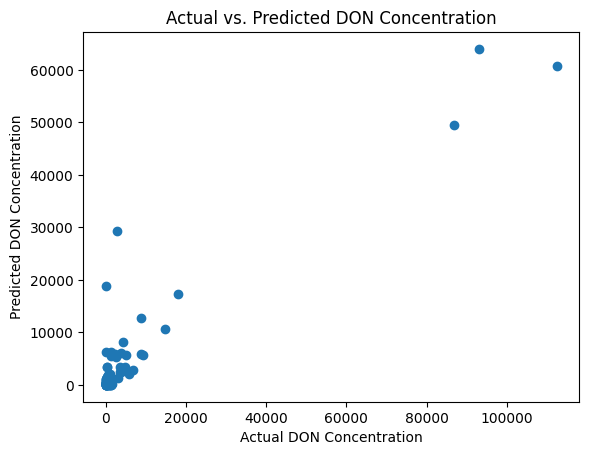

In [133]:
plt.scatter(y_test_np, predictions)
plt.plot([min(y_test_np), max(y_test_np)], 
             [min(y_test_np), max(y_test_np)], 
             'r--', label='Perfect Prediction')
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Actual vs. Predicted DON Concentration")
plt.show()